In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import warnings 
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv("data/Insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [6]:
data.shape

(1338, 8)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   sex             1338 non-null   int64  
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   int64  
 5   region          1338 non-null   int64  
 6   charges         1338 non-null   float64
 7   insuranceclaim  1338 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 83.8 KB


In [8]:
data.isnull().sum()

age               0
sex               0
bmi               0
children          0
smoker            0
region            0
charges           0
insuranceclaim    0
dtype: int64

In [9]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [10]:
[f" {col} : {data[col].nunique()}" for col in data.columns]

[' age : 47',
 ' sex : 2',
 ' bmi : 548',
 ' children : 6',
 ' smoker : 2',
 ' region : 4',
 ' charges : 1337',
 ' insuranceclaim : 2']

In [11]:
nf = []; cf = []
for col in data.drop(['insuranceclaim'], axis=1).columns: 
    if data[col].nunique() > 7: 
        nf.append(col)
    else: 
        cf.append(col)

### EDA

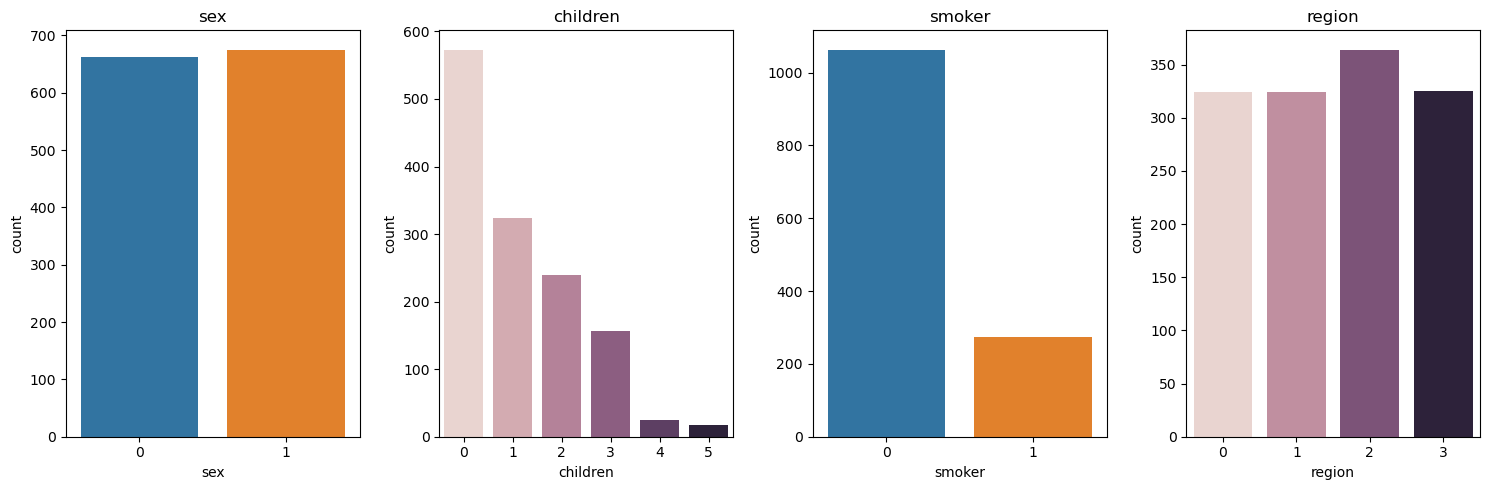

In [12]:
plt.figure(figsize=(15,5))
for i,col in enumerate(cf, 1): 
    plt.subplot(1,4,i)
    sns.countplot(x=col, data=data, hue = col)
    plt.title(col)
    plt.xticks(rotation = 0)
    plt.legend().remove()
plt.tight_layout()
plt.show()

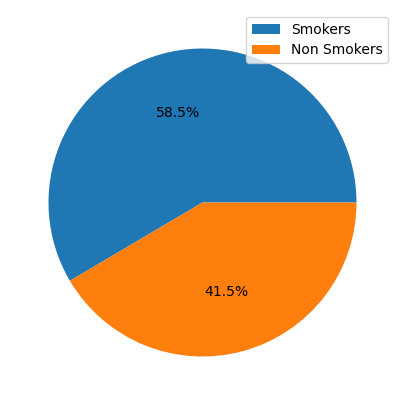

In [13]:
data['insuranceclaim'].value_counts()
plt.figure(figsize=(5,5))
plt.pie(data['insuranceclaim'].value_counts(), autopct='%1.1f%%', radius=1)
plt.legend(['Smokers','Non Smokers'])
plt.show()

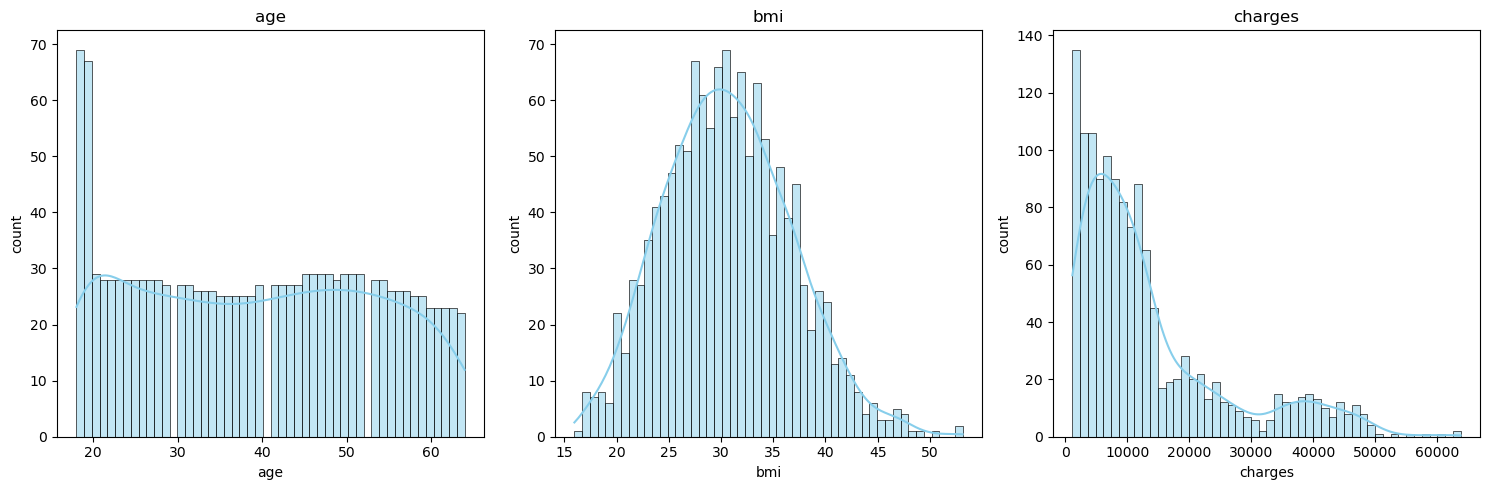

In [14]:
plt.figure(figsize=(15,5))
for i,col in enumerate(nf, 1): 
    plt.subplot(1,3,i)
    sns.histplot(data[col], kde=True, color='skyblue', bins=50)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("count")
plt.tight_layout()
plt.show()

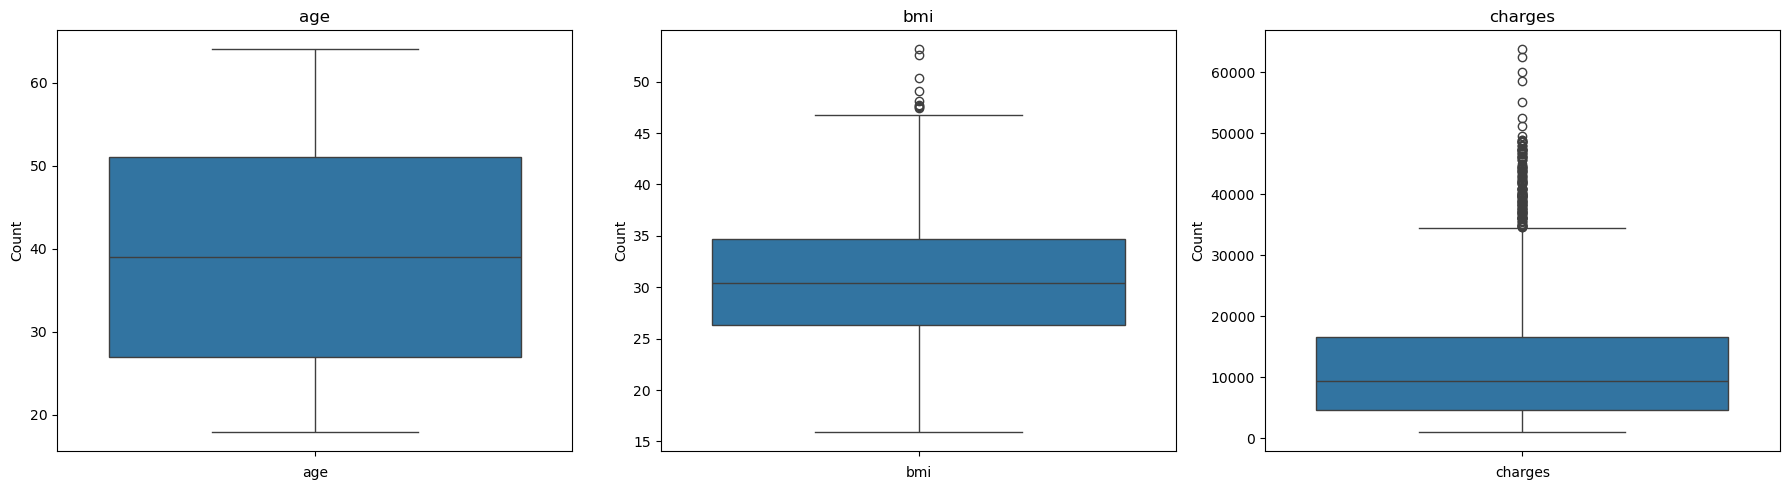

In [15]:
plt.figure(figsize=(18, 5))
for i, col in enumerate(nf, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data[col])
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

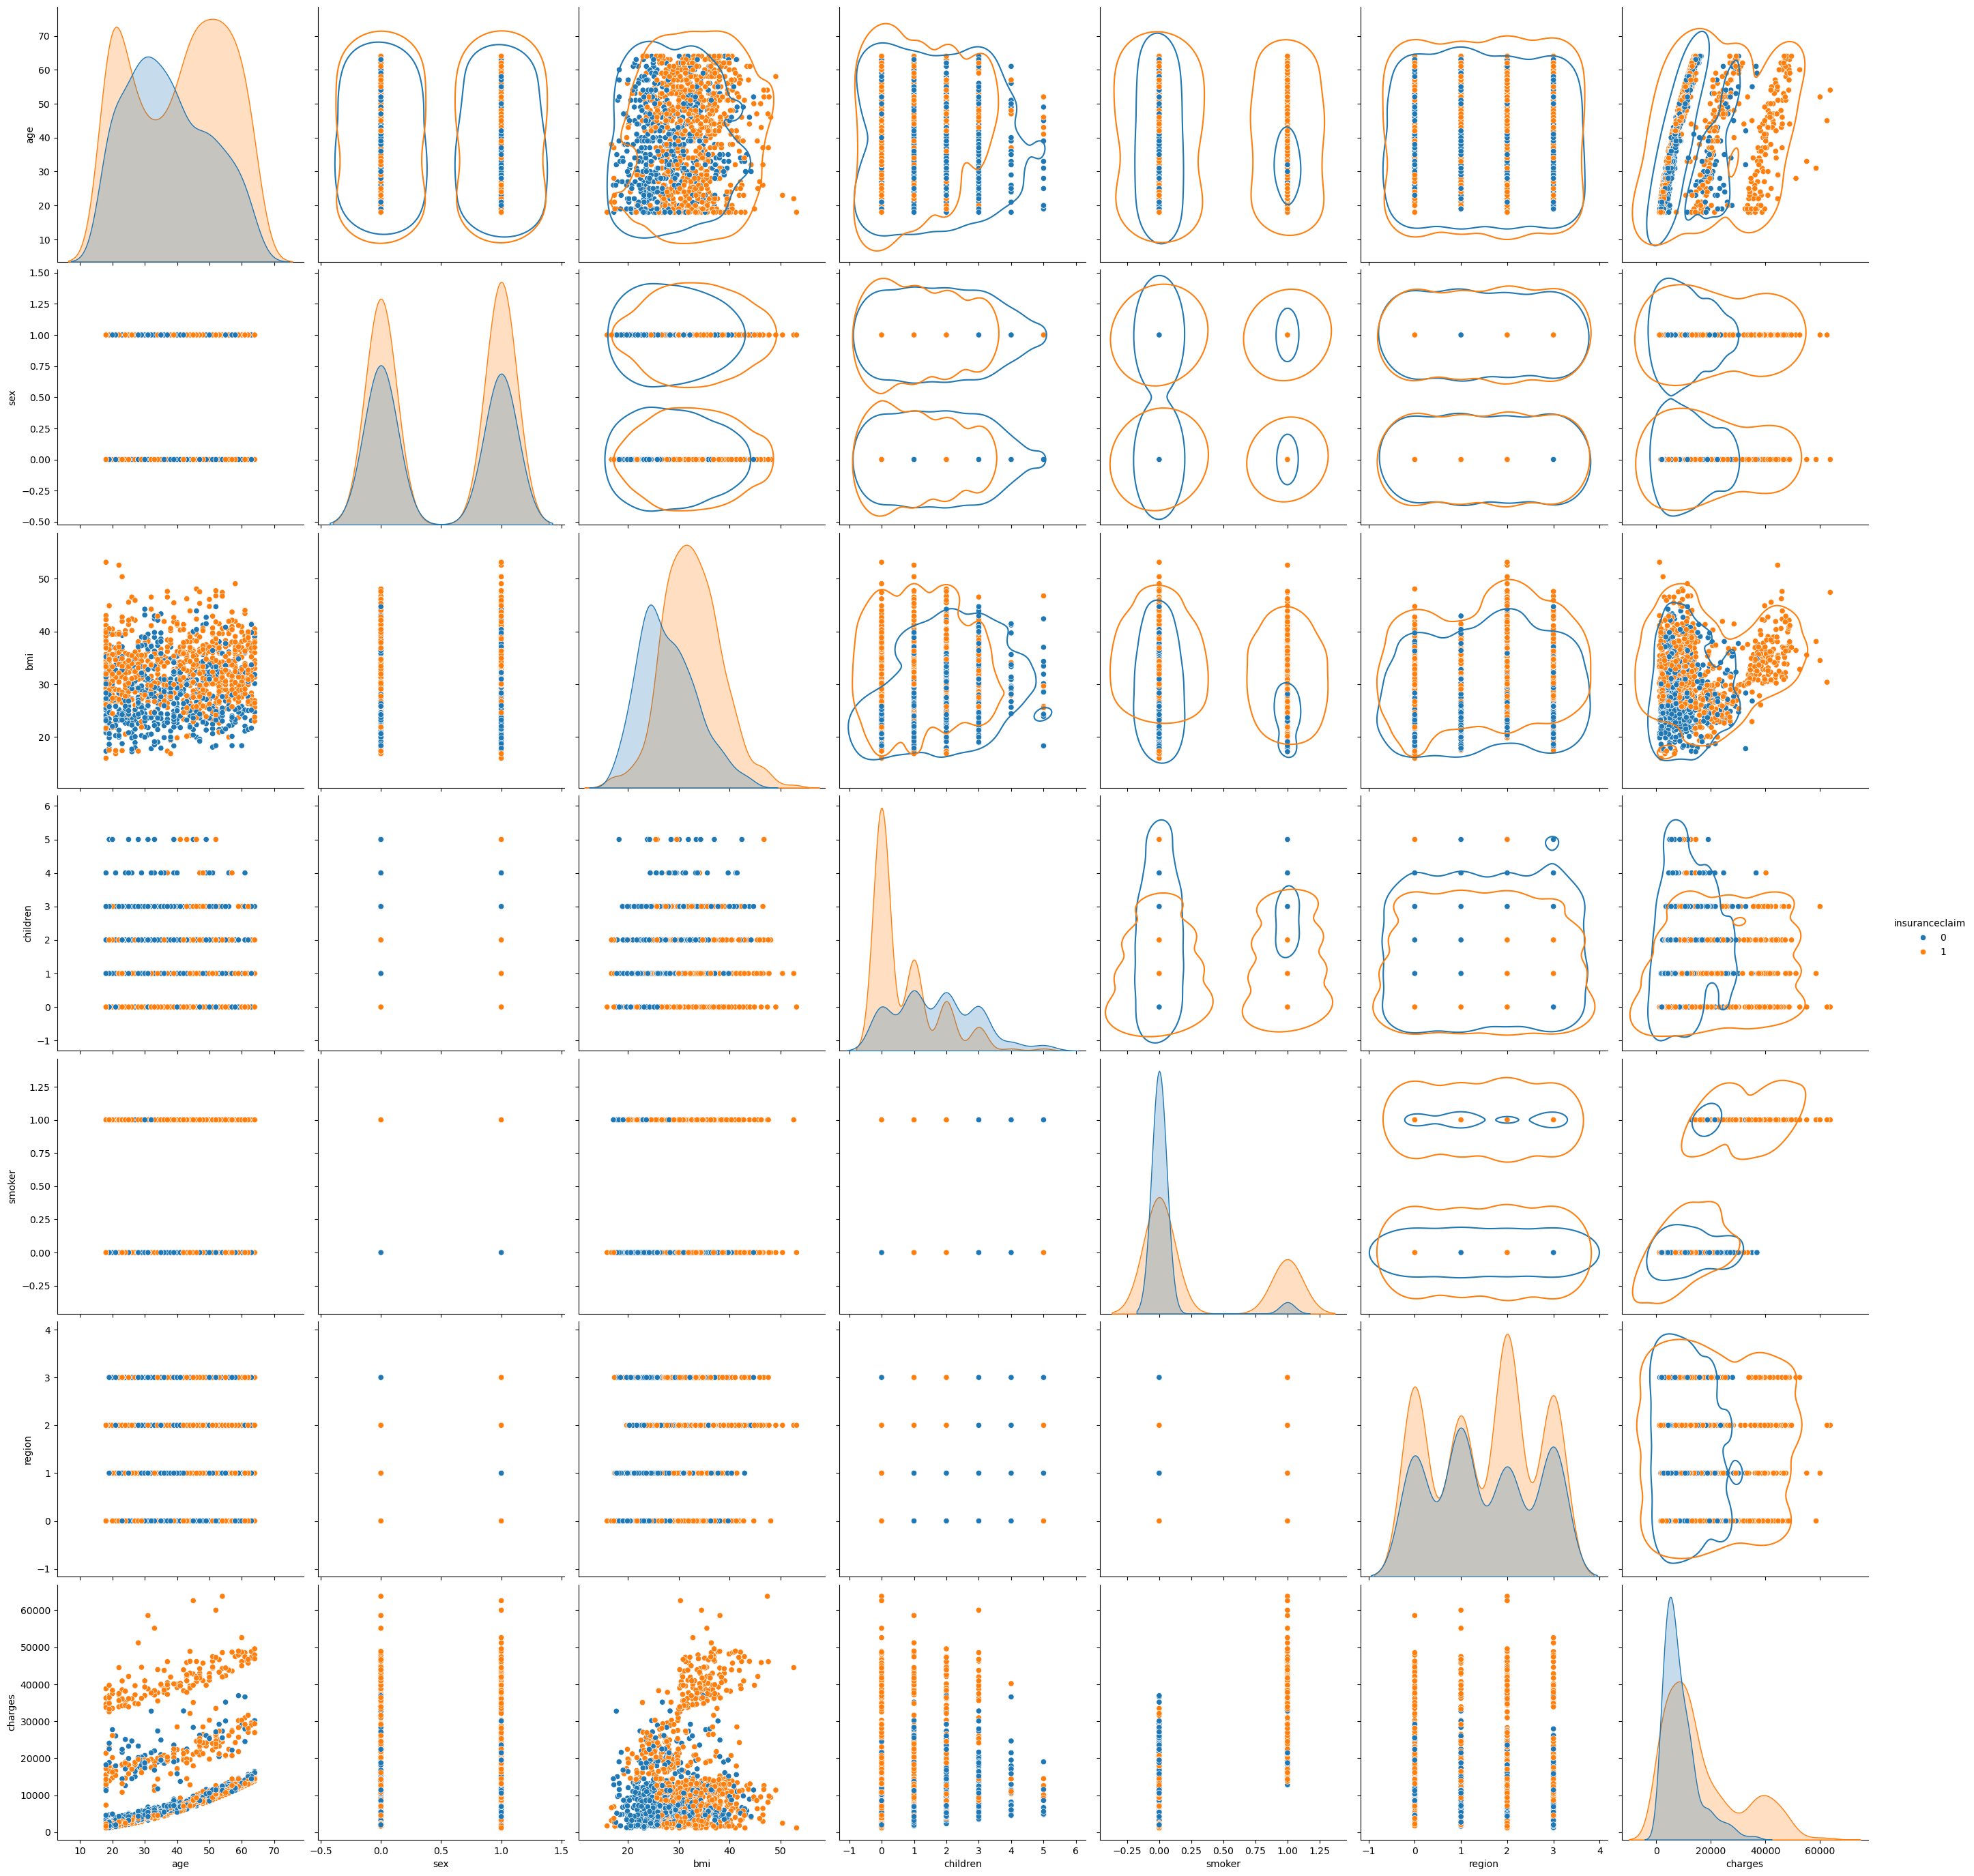

In [13]:
target = 'insuranceclaim'
g=sns.pairplot(data, hue=target, height=4)
g.map_upper(sns.kdeplot, levels=1, color=".2")
plt.show()

### Handling Outliers

In [16]:
## Since bmi almost follows a normal distribution 
upper_bound = data['bmi'].mean() + 3*data['bmi'].std()
lower_bound = data['bmi'].mean() - 3*data['bmi'].std()
print(lower_bound), print(upper_bound), print(data['bmi'].mean())

12.362046528819015
48.96485698651382
30.66345175766642


(None, None, None)

In [17]:
# charges does not follow a normal distribution 
# checking for both mild and extreme outliers 


IQR = data['charges'].quantile(0.75) - data['charges'].quantile(0.25) 

lower_bridge = data['charges'].quantile(0.25) - (IQR*3)
upper_bridge = data['charges'].quantile(0.75) + (IQR*3)

lower_bridge_m = data['charges'].quantile(0.25) - (IQR*1.5)
upper_bridge_m = data['charges'].quantile(0.75) + (IQR*1.5)

print("Extreme Outliers : "), print(lower_bridge), print(upper_bridge)
print()
print("Mild Outliers: "), print(lower_bridge_m), print(upper_bridge_m)

Extreme Outliers : 
-30987.776349999996
52391.837799999994

Mild Outliers: 
-13120.716174999998
34524.777625


(None, None, None)

In [18]:
data2 = data.copy()

In [19]:
# for bmi - the outliers are being replaced with the lower and upper bound 
data2.loc[data2['bmi'] >= 48,'bmi'] = 48
data2.loc[data2['bmi'] <= 12,'bmi'] = 12

In [20]:
# for charges - we are replacing the extreme outliers
data2.loc[data2['charges'] >= 52391,'charges'] = 52391
data2.loc[data2['charges'] <= -30987,'charges'] = -30987

In [21]:
data2.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


### Scaling the num feature, OHE cat features, fixing the imbalance

In [22]:
data2 = pd.get_dummies(data2, columns=cf, drop_first=True, dtype='int')

In [23]:
data2.columns

Index(['age', 'bmi', 'charges', 'insuranceclaim', 'sex_1', 'children_1',
       'children_2', 'children_3', 'children_4', 'children_5', 'smoker_1',
       'region_1', 'region_2', 'region_3'],
      dtype='object')

In [21]:
data2.head()

,age,bmi,charges,insuranceclaim,sex_1,children_1,children_2,children_3,children_4,children_5,smoker_1,region_1,region_2,region_3
0,19,27.900,16884.92400,1,0,0,0,0,0,0,1,0,0,1
1,18,33.770,1725.55230,1,1,1,0,0,0,0,0,0,1,0
2,28,33.000,4449.46200,0,1,0,0,1,0,0,0,0,1,0
3,33,22.705,21984.47061,0,1,0,0,0,0,0,0,1,0,0
4,32,28.880,3866.85520,1,1,0,0,0,0,0,0,1,0,0


In [22]:
# Fixing the imbalance using SMOTE technique 

In [23]:
cf_new = [col for col in data2.columns if col not in nf]

scaler = StandardScaler()

scaled_nf = scaler.fit_transform(data[nf])

scaled_nf_df = pd.DataFrame(scaled_nf, columns=nf)

final_data = pd.concat([scaled_nf_df, data2[cf_new].reset_index(drop=True)],axis=1)
final_data

,age,bmi,charges,insuranceclaim,sex_1,children_1,children_2,children_3,children_4,children_5,smoker_1,region_1,region_2,region_3
0,-1.440418,-0.453160,0.297857,1,0,0,0,0,0,0,1,0,0,1
1,-1.511647,0.509422,-0.954381,1,1,1,0,0,0,0,0,0,1,0
2,-0.799350,0.383155,-0.729373,0,1,0,0,1,0,0,0,0,1,0
3,-0.443201,-1.305052,0.719104,0,1,0,0,0,0,0,0,1,0,0
4,-0.514431,-0.292456,-0.777499,1,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,0.767704,0.050269,-0.221263,0,1,0,0,1,0,0,0,1,0,0
1333,-1.511647,0.206053,-0.914695,1,0,0,0,0,0,0,0,0,0,0
1334,-1.511647,1.014490,-0.962287,1,0,0,0,0,0,0,0,0,1,0
1335,-1.297958,-0.797524,-0.931054,0,0,0,0,0,0,0,0,0,0,1


In [24]:
import pickle 
with open('scaler.pkl','wb') as f: 
    pickle.dump(scaler, f)

### Train Test split 

In [25]:
X = final_data.drop(['insuranceclaim'], axis=1)
y = final_data['insuranceclaim']

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.20, random_state=42)
X_train.reset_index(drop=True,inplace=True)

In [26]:
X_train.shape, X_test.shape

((1069, 13), (268, 13))

### Feature selection

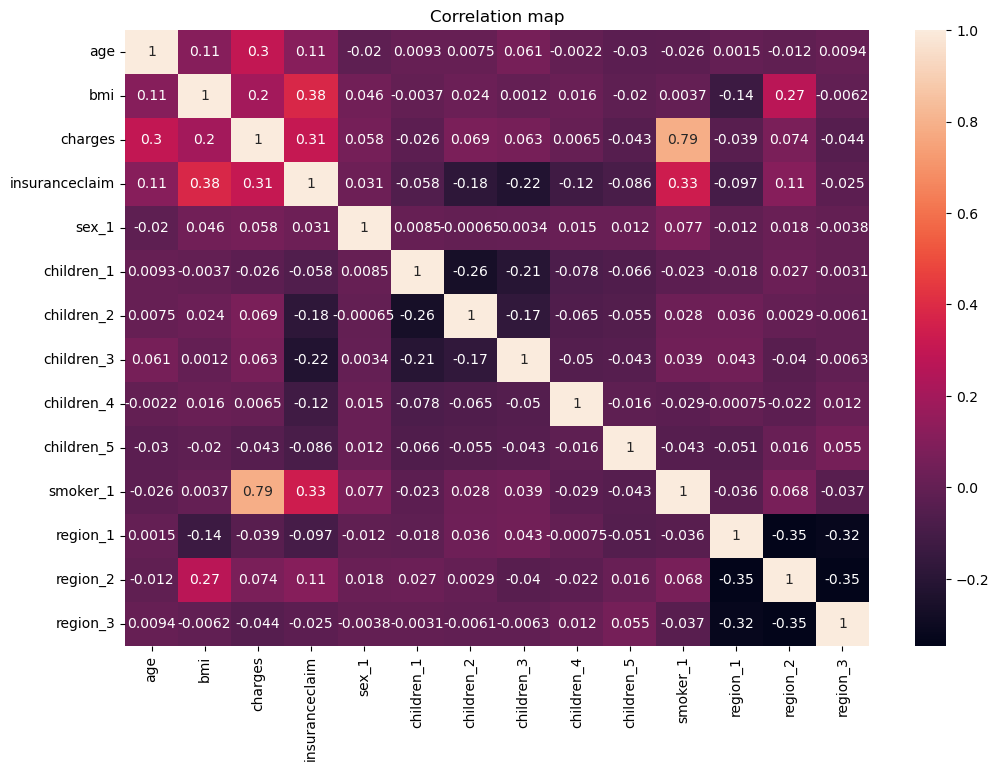

In [27]:
plt.figure(figsize = (12,8))
sns.heatmap(final_data.corr(), annot=True)
plt.title("Correlation map")
plt.show()

In [28]:
## VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor 

x = final_data
vif_data = pd.DataFrame()
vif_data['features'] = x.columns
vif_data['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif_data

,features,VIF
0,age,1.415621
1,bmi,1.411715
2,charges,3.927717
3,insuranceclaim,2.827930
4,sex_1,1.872785
5,children_1,1.394924
6,children_2,1.332832
7,children_3,1.250895
8,children_4,1.039768
9,children_5,1.036368


In [29]:
import statsmodels.api as sm
logit_model = sm.Logit(y, sm.add_constant(X)).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.358761
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         insuranceclaim   No. Observations:                 1337
Model:                          Logit   Df Residuals:                     1323
Method:                           MLE   Df Model:                           13
Date:                Mon, 14 Apr 2025   Pseudo R-squ.:                  0.4714
Time:                        17:44:07   Log-Likelihood:                -479.66
converged:                       True   LL-Null:                       -907.37
Covariance Type:            nonrobust   LLR p-value:                1.843e-174
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1355      0.232      9.196      0.000       1.680       2.591
age            0.4164      0.

In [30]:
## Logistic Regression 

lr = LogisticRegression()

# Hyperparameter Grid 
params_dist = {
    'C': np.linspace(-4,4,20), 
    'penalty': ['l1','l2'], 
    'solver': ['libliner','saga''newton-cholesky','lbfgs','newton-cg'],
    'max_iter':[100,200,300,500],
    'class_weight': ['balanced']
}

# Randomized Search CV 
rs = RandomizedSearchCV(
    estimator=lr, 
    param_distributions=params_dist, 
    n_iter=50, 
    scoring='accuracy', 
    cv=5, 
    verbose=1,
    n_jobs=-1, 
    random_state=2
)

rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([-4.        , -3.57894737, -3.15789474, -2.73684211, -2.31578947,
       -1.89473684, -1.47368421, -1.05263158, -0.63157895, -0.21052632,
        0.21052632,  0.63157895,  1.05263158,  1.47368421,  1.89473684,
        2.31578947,  2.73684211,  3.15789474,  3.57894737,  4.        ]),
                                        'class_weight': ['balanced'],
                                        'max_iter': [100, 200, 300, 500],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['libliner',
                                                   'saganewton-cholesky',
                                                   'lbfgs', 'newton-cg']},
                   random_state=2, scoring='accuracy', verbose=1)

In [31]:
# Best parameter and score 
print("Best Params: ", rs.best_params_)
print()
print("Best Score (Cross-Validation): ", rs.best_score_)
print()

# Evaluate on test set 
best_model = rs.best_estimator_
y_pred = best_model.predict(X_test)

print("classification report: \n", classification_report(y_test, y_pred))
print("accuracy score: ", accuracy_score(y_test, y_pred))

Best Params:  {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'class_weight': 'balanced', 'C': 1.473684210526315}

Best Score (Cross-Validation):  0.8531657233118336

classification report: 
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       117
           1       0.92      0.89      0.91       151

    accuracy                           0.90       268
   macro avg       0.89      0.90      0.89       268
weighted avg       0.90      0.90      0.90       268

accuracy score:  0.8955223880597015


In [32]:

## RandomForest Classifier
rf = RandomForestClassifier(random_state=42)

# number of trees in random forest 
n_estimator=[int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# number of features to consider at every split 
max_features = ['auto','sqrt','log2']
# maximum number of levels in tree 
max_depth = [int(x) for x in np.linspace(10,1000,10)]
# minimum number of samples required to split a node 
min_samples_split=[2,5,10,14]
# minimum number of samples required at each leaf node 
min_samples_leaf = [1,2,4,6,8]

params_dist = {
    'n_estimators': n_estimator, 
    'max_features': max_features,
    'max_depth': max_depth, 
    'min_samples_split': min_samples_split, 
    'min_samples_leaf': min_samples_leaf,
    'criterion': ['entropy','gini']
}


In [33]:
rs_rf = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=params_dist, 
    n_iter=50, 
    scoring='accuracy', 
    cv = 5, 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

#Fit the model 
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='accuracy', verbose=1)

In [34]:
# Best params and cross validation score
print("Best Params: ", rs_rf.best_params_)
print("Best Score (Cross Validation):", rs_rf.best_score_)

# Evaluate the test set 
best_rf = rs_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("classification report: \n", classification_report(y_test, y_pred_rf))
print("accuracy score: ", accuracy_score(y_test, y_pred_rf))

Best Params:  {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 340, 'criterion': 'entropy'}
Best Score (Cross Validation): 0.92795401693651
classification report: 
               precision    recall  f1-score   support

           0       0.97      0.89      0.93       117
           1       0.92      0.98      0.95       151

    accuracy                           0.94       268
   macro avg       0.95      0.93      0.94       268
weighted avg       0.94      0.94      0.94       268

accuracy score:  0.9402985074626866


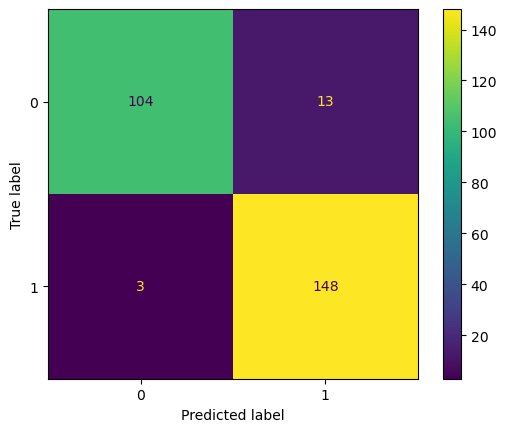

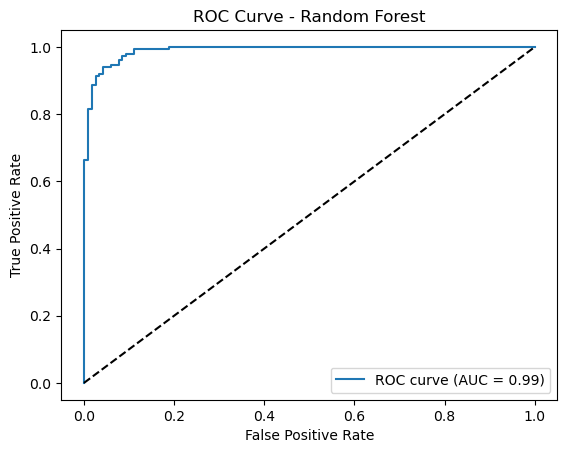

In [35]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# ROC Curve
y_prob = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

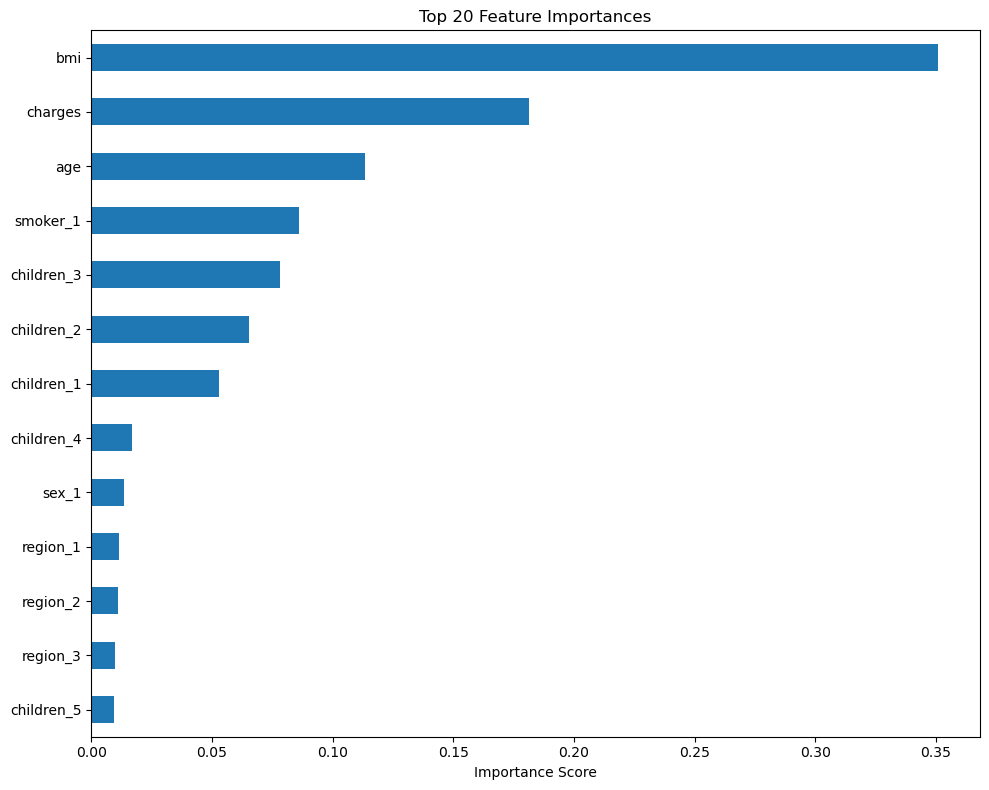

In [36]:
# Assuming X_train is a DataFrame
importances = best_rf.feature_importances_
feature_names = X_train.columns

feat_imp = pd.Series(importances, index=feature_names)
feat_imp.nlargest(20).plot(kind='barh', figsize=(10,8))
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [38]:
with open('model.pkl', 'wb') as file:
    pickle.dump(rs_rf, file)

In [ ]:
# with open('model.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)